# Argo Density Sections

In this notebook, I'll move from the argo_sections framework (where everything was plotted in depth coordinates) to using density as the vertical coordinate. I'm hoping this is already largely possible within the functions I've written. The first step is to save ds_rho versions for each section (from the methods in argo_box_loader) and then used to make the plots in argo_sections.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw

import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import processing_funcs as prf

In [ ]:
reload(df)
reload(ef)
reload(ff)

### Load Sections in Density Space

In [2]:
#Pacific Section, z coordinates
z5 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-180,-178)_lat:(-70,70)_ds_z.nc')
z5_SIG1 = gsw.density.sigma1(z5.SA, z5.CT)
z5 = z5.assign(SIG1=(['N_PROF','PRES_INTERPOLATED'], z5_SIG1.data))

#Atlantic Section, z coordinates
z8 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-25,-23)_lat:(-70,70)_ds_z.nc')
z8_SIG1 = gsw.density.sigma1(z8.SA, z8.CT)
z8 = z8.assign(SIG1=(['N_PROF','PRES_INTERPOLATED'], z8_SIG1.data))

In [ ]:
rho5_grid = np.linspace(20.5,28,1000)
rho8_grid = np.linspace(21,28,1000)

In [ ]:
print(z8.SIG0.min(),z8.SIG0.max())

In [ ]:
rho8      = df.interpolate2density_prof(z8, rho8_grid)
rho8

In [ ]:
rho8.to_netcdf('swot/SUM05/amf2288/sync-boxes/lon:(-25,-23)_lat:(-70,70)_ds_rho.nc')

### Adding EKE Dimension

In [3]:
rho5 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-180,-178)_lat:(-70,70)_ds_rho.nc')
rho8 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-25,-23)_lat:(-70,70)_ds_rho.nc')

In [4]:
scales = [50,100,200]
sample_max = 12
variables = ['CT','SA','SPICE']

In [5]:
rho5_EKEct = ef.get_EKE_da(rho5.transpose(),scales,sample_max,variables[0],dim1='N_PROF_NEW',dim2='rho_grid')
rho5_EKEsa = ef.get_EKE_da(rho5.transpose(),scales,sample_max,variables[1],dim1='N_PROF_NEW',dim2='rho_grid')
rho5_EKEsp = ef.get_EKE_da(rho5.transpose(),scales,sample_max,variables[2],dim1='N_PROF_NEW',dim2='rho_grid')

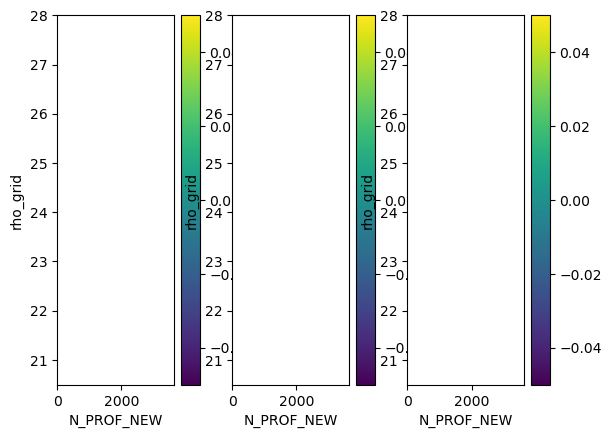

In [6]:
plt.subplot(1,3,1)
rho5_EKEct.isel(EKE=0).plot(y='rho_grid')
plt.subplot(1,3,2)
rho5_EKEsa.isel(EKE=0).plot(y='rho_grid')
plt.subplot(1,3,3)
rho5_EKEsp.isel(EKE=0).plot(y='rho_grid')

I tried to load the EKE like the argo_sections notebook, but it returned a dataset with all NaNs, I believe because there are lots of NaNs in this dataset, since not all profiles have samples at the same densities. I think this means I'll have to write an interpolation function similar to the one for observed data for converting EKEs to density coordinates. I don't think that will be very difficult, but it will take lots of time to run that function for three variables and two sections.

The next effort is to rewrite the interpolation functions to apply to EKE datasets. This sound deceptively simple, but I'm a bit worried because I don't really know how the interpolation functions work... The main thing I'm thinking about is that the EKE datasets have 3 dimensions: depth, profiles, _and_ EKE value. This third dimension is really important to preserve.

I think you should try to understand as much as possible yourself (maybe try to adapt now?) and then ask Dhruv for advice on how to approach this problem. 

In [7]:
z5_EKEct = ef.get_EKE_da(z5,scales,sample_max,variables[0])
z5_EKEsa = ef.get_EKE_da(z5,scales,sample_max,variables[1])
z5_EKEsp = ef.get_EKE_da(z5,scales,sample_max,variables[2])

In [23]:
z5_EKEct = z5_EKEct.sortby('LATITUDE').where(z5_EKEct.mask==1).isel(EKE=1)
z5_EKEsa = z5_EKEsa.sortby('LATITUDE').where(z5_EKEsa.mask==1).isel(EKE=1)
z5_EKEsp = z5_EKEsp.sortby('LATITUDE').where(z5_EKEsp.mask==1).isel(EKE=1)

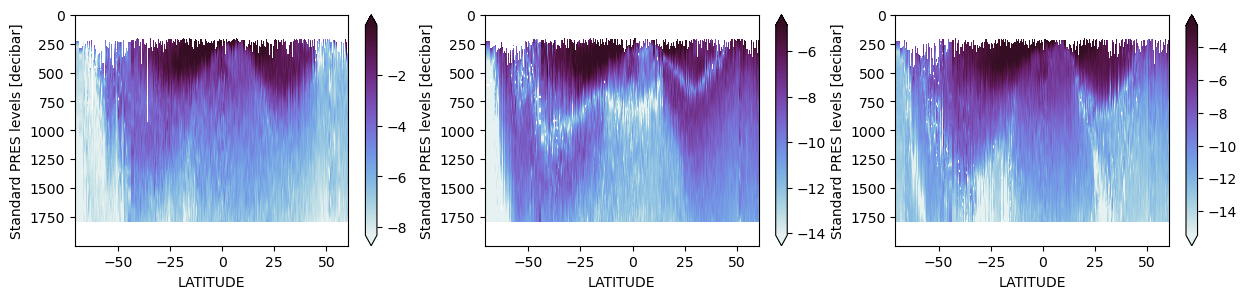

In [27]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
np.log(z5_EKEct).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
np.log(z5_EKEsa).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
np.log(z5_EKEsp).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
plt.gca().invert_yaxis()

In [ ]:
def func_var_int(ds, variable, rho_grid, dim1='N_PROF_NEW', dim2='PRES_INTERPOLATED', flag='group'):
    
    N_PROF_num = ds[dim1].values
    
    rho = ds.SIG0
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    
    var_nonan = ds[variable].where(~np.isnan(rho), drop=True)
    
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', dim1],
                        coords = {'rho_grid': rho_grid, dim1: [N_PROF_num]}).rename(variable)



def interpolate2density_prof(ds_z, rho_grid, dim1='N_PROF_NEW', dim2='PRES_INTERPOLATED'):
    
    N_PROF_ind = 0
    PRES_tilde_xr  = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES',rho_grid)
    CT_tilde_xr    = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT',rho_grid)
    SA_tilde_xr    = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)
    SIG0_tilde_xr  = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)
    SIG1_tilde_xr  = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG1', rho_grid)
    SPICE_tilde_xr = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)
    
    

    for N_PROF_ind in range(1, len(ds_z.N_PROF)):
        if np.mod(N_PROF_ind, 100)==0:
            print(N_PROF_ind)
        PRES_tilde_xr  = xr.concat([PRES_tilde_xr,  func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES', rho_grid)], dim=dim1)
        CT_tilde_xr    = xr.concat([CT_tilde_xr,    func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT', rho_grid)], dim=dim1)
        SA_tilde_xr    = xr.concat([SA_tilde_xr,    func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)], dim=dim1)
        SIG0_tilde_xr  = xr.concat([SIG0_tilde_xr,  func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)], dim=dim1)
        SIG1_tilde_xr  = xr.concat([SIG1_tilde_xr,  func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)], dim=dim1)
        SPICE_tilde_xr = xr.concat([SPICE_tilde_xr, func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)], dim=dim1)
    

    ds_rho = xr.merge([PRES_tilde_xr, CT_tilde_xr,
                             SA_tilde_xr, SIG0_tilde_xr, SIG1_tilde_xr, SPICE_tilde_xr])
    
    ds_rho = ds_rho.assign_coords(TIME      =('N_PROF_NEW',ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =('N_PROF_NEW',ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =('N_PROF_NEW',ds_z.LONGITUDE.data))
    ds_rho = ds_rho.assign_coords(MLD       =('N_PROF_NEW',ds_z.MLD.data))
    ds_rho = ds_rho.assign_coords(month     =('N_PROF_NEW',ds_z.month.data))
    ds_rho = ds_rho.assign_coords(month_frac=('N_PROF_NEW',ds_z.month_frac.data))
    ds_rho = ds_rho.assign_coords(year      =('N_PROF_NEW',ds_z.year.data))
    ds_rho = ds_rho.assign_coords(year_frac =('N_PROF_NEW',ds_z.year_frac.data))
    
    return ds_rho

### Section Plots

In [9]:
rho5 = rho5.sortby('LATITUDE')

Text(0.5, 1.0, 'First Derivative of Conservative Temperature')

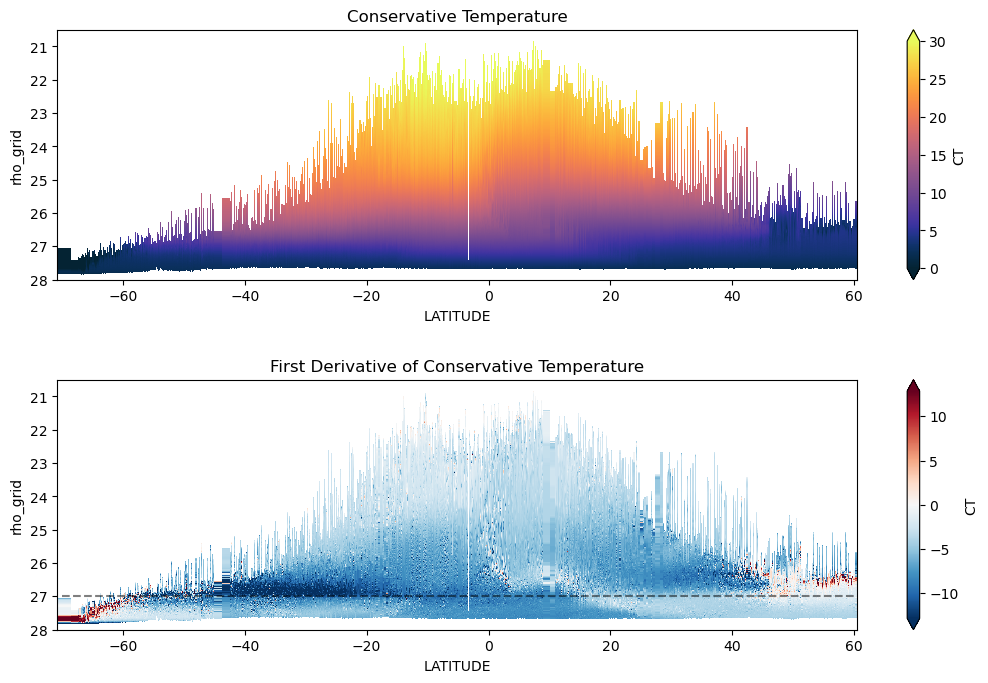

In [10]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_axes([0,1,1,0.5])
rho5.CT.plot(x='LATITUDE',y='rho_grid',ax=ax1,vmin=0,vmax=30,cmap=cmo.thermal)
ax1.set_ylim(ax1.get_ylim()[::-1])
plt.title('Conservative Temperature')

ax2 = fig.add_axes([0,0.3,1,0.5])
rho5.CT.differentiate('rho_grid').plot(x='LATITUDE',y='rho_grid',ax=ax2,robust=True)
ax2.hlines(27,-70,60,color='k',linestyle='--',alpha=0.5)
ax2.set_ylim(ax2.get_ylim()[::-1])
plt.title('First Derivative of Conservative Temperature')

Text(0.5, 1.0, 'First Derivative of Absolute Salinity')

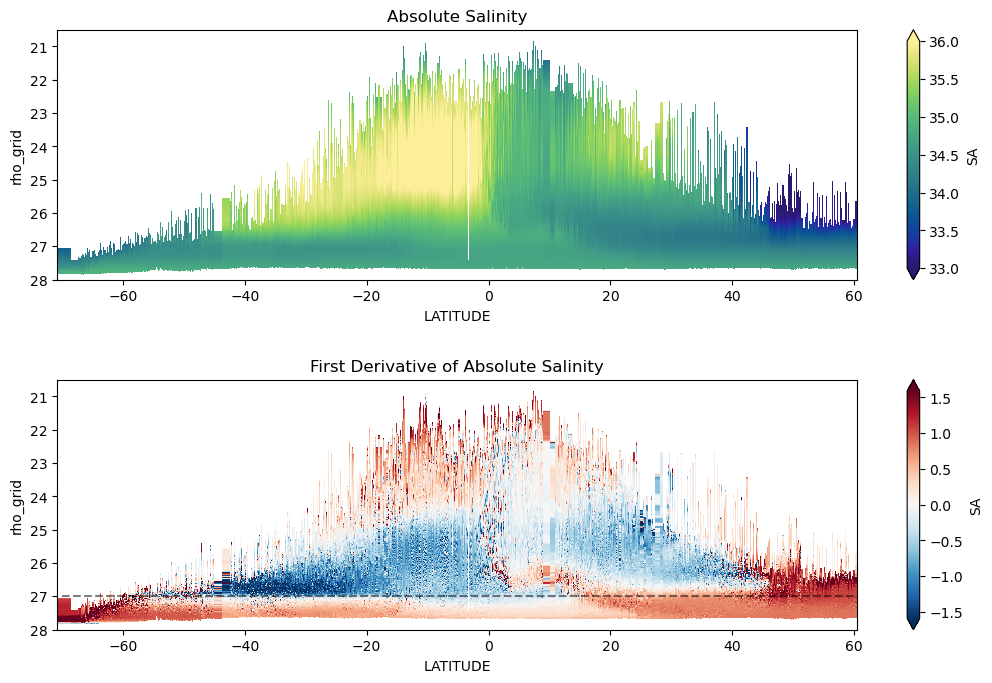

In [11]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_axes([0,1,1,0.5])
rho5.SA.plot(x='LATITUDE',y='rho_grid',ax=ax1,vmin=33,vmax=36,cmap=cmo.haline)
ax1.set_ylim(ax1.get_ylim()[::-1])
plt.title('Absolute Salinity')

ax2 = fig.add_axes([0,0.3,1,0.5])
rho5.SA.differentiate('rho_grid').plot(x='LATITUDE',y='rho_grid',ax=ax2,robust=True)
ax2.hlines(27,-70,60,color='k',linestyle='--',alpha=0.5)
ax2.set_ylim(ax2.get_ylim()[::-1])
plt.title('First Derivative of Absolute Salinity')

Text(0.5, 1.0, 'First Derivative of Spice')

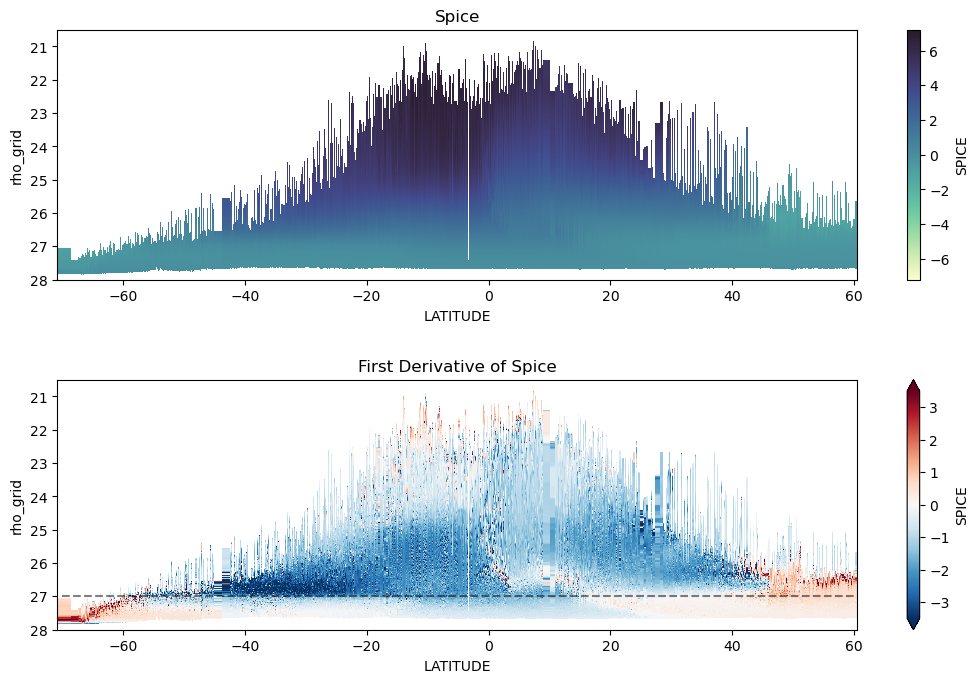

In [12]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_axes([0,1,1,0.5])
rho5.SPICE.plot(x='LATITUDE',y='rho_grid',ax=ax1,cmap=cmo.deep)
ax1.set_ylim(ax1.get_ylim()[::-1])
plt.title('Spice')

ax2 = fig.add_axes([0,0.3,1,0.5])
rho5.SPICE.differentiate('rho_grid').plot(x='LATITUDE',y='rho_grid',ax=ax2,robust=True)
ax2.hlines(27,-70,60,color='k',linestyle='--',alpha=0.5)
ax2.set_ylim(ax2.get_ylim()[::-1])
plt.title('First Derivative of Spice')